# Tutorial 1: Pipeline Equation Derivation

In [1]:
%matplotlib inline

## 1. Pipeline flow equation

There are several gas pipeline equations can be used to calculate the pipeline steady-state flow rate. The common variants are mostly originates from the 1st order Euler isothermal equations, where the first equation represents the mass conservation and the second on the energy.

$$
\frac{\partial\rho}{\partial t}+\frac{\partial(\rho v)}{\partial x} = 0,\\ \frac{\partial(\rho v)}{\partial t}+\frac{\partial(\rho v^2)}{\partial x}+\frac{\partial p}{\partial x}+f \frac{v|v|}{2D}\rho+\rho g \sin\theta=0
$$

In the static case, the velocity of the gas flow $v$ keeps constant along the pipeline and the density $\rho$ does not vary during time. Therefore, the first equation and the first two terms in the second equation can be neglected. So now we have:

$$
\frac{\partial p}{\partial x} + \frac{f\rho}{2D}|v|v + \rho g\sin(\theta) = 0
$$

Now let's assume that the volumetric gas flow rate $Q = A\cdot v$, where $A$ is the cross-section area of the pipe. And $\rho = \frac{MP}{ZRT}$, where $M=dM_{air}$ is the molar mass of gas ($d$ is the relative density and $M_{air}$ is the air molar mass which is around 28.96 g/mol), $P$ is the pressure, $Z$ is the gas compressibility factor and $R $ is the gas constant (8314.41 J/(kmol K)), $T$ is the temperature in K. So we get:

$$
\frac{\partial P}{\partial x} + \frac{fMP}{2ZRTDA^2}|Q|Q + g\sin(\theta)\frac{PM}{ZRT} = 0
$$

Because now $P$ is only dependent on $x$, so we change the partial derivative symbol to $\mathrm{d}$.

$$
\mathrm{d}P = -\frac{fMP}{2ZRTDA^2}|Q|Q\mathrm{d}x - g\sin(\theta)\frac{PM}{ZRT}\mathrm{d}x
$$

Multiplying both sides with $\rho$ ($\rho=\frac{MP}{ZRT}$)

$$
\frac{MP}{ZRT}\mathrm{d}P = -\frac{fM^2P^2}{2Z^2R^2T^2DA^2}|Q|Q\mathrm{d}x - g\sin(\theta)\frac{P^2M^2}{Z^2R^2T^2}\mathrm{d}x
$$

Now the only variables we have in the equation are the pressure $P$ and the volumetric flow rate $Q$, which are the ones we use to model our gas flow simulation. Now we calculate the integral of the above equation and we can get:

$$
\frac{M}{ZRT}\frac{P_2^2-P_1^2}{2} = -\frac{fM^2P^2}{2Z^2R^2T^2DA^2}|Q|QL - g\sin(\theta)\frac{P^2M^2}{Z^2R^2T^2}L
$$

Because we have replaced $\rho$ with $\frac{MP}{ZRT}$ and the density of the gas mixture depends on the pressure and temperature of the gas mixture. And the compressibility factor $Z$ also depends on the gas temperature and pressure. Therefore we assume there exists an average value for the pressure, temperature and compressibility factor of the transported gas mixture.

$$
\frac{M}{Z_{avg}RT_{avg}}\frac{P_2^2-P_1^2}{2} = -\frac{fM^2P_{st}^2}{2Z_{st}^2R^2T_{st}^2DA^2}|Q_{st}|Q_{st}L - g\sin(\theta)\frac{P_{avg}^2M^2}{Z_{avg}^2R^2T_{avg}^2}L
$$

By some further simplifications we can get the flow equation we need for our steady-state gas flow simulation.
$$
Q = \pm\pi\sqrt{\frac{R}{16M_{air}}}\frac{T_{st}}{P_{st}}D^{2.5}\sqrt{\frac{|P_1^2-P_2^2-2g\sin\theta L\frac{P_{avg}^2dM_{air}}{Z_{avg}RT_{avg}}|}{LdTZ_{avg}f}}
$$

### Import dependencies and assign constants

In [1]:
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.constants import bar, atm, zero_Celsius, pi, R, g

In [2]:
print(f"1 bar = {bar} Pa")
print(f"1 atm = {atm} Pa")
print(f"0 degree Celsius = {zero_Celsius} K")
print(f"The gas constant R is: {R} J⋅K^(−1)⋅mol^(−1)")
print(f"standard acceleration of gravity: {g} m/s^2")

1 bar = 100000.0 Pa
1 atm = 101325.0 Pa
0 degree Celsius = 273.15 K
The gas constant R is: 8.314462618 J⋅K^(−1)⋅mol^(−1)
standard acceleration of gravity: 9.80665 m/s^2


In [3]:
# Define constant variables
STANDARD_TEMPERATURE = 15 + zero_Celsius  # standard temperature (15 degree Celsius in K)
STANDARD_PRESSURE = 1 * atm  # standard pressure in Pa
STANDARD_TEMPERATURE, STANDARD_PRESSURE

(288.15, 101325.0)

In [5]:
# Natural gas properties
RD = 0.554  # relative density d in the equation above
Z = 0.894  # compressibility factor of gas
# Average molar mass of air
M_AIR = 28.97  # g/mol

### Define the functions to calculate flow rate

$$
Q = \pm\pi\sqrt{\frac{R}{16M_{air}}}\frac{T_{st}}{P_{st}}D^{2.5}\sqrt{\frac{|P_1^2-P_2^2-2g\sin\theta L\frac{P_{avg}^2dM_{air}}{Z_{avg}RT_{avg}}|}{LdTZ_{avg}f}}
$$

\begin{equation}
Q_{st} = sgn(P_1,P_2,E)\cdot C_1 \frac{T_{st}}{P_{st}}\left(\frac{|P_1^2-P_2^2-E|}{LdT_{avg}Z_{avg}}\right)^{0.5}\frac{D^{2.5}}{\sqrt{f}}\\\\
\end{equation}

\begin{equation}
sgn(P_1,P_2,E) = \left\{\begin{aligned}
 1&,~if ~P_1^2-P_2^2-E\ge0,\\
 -1&,~if~P_1^2-P_2^2-E<0.
\end{aligned} \right.
\end{equation}

\begin{equation}
E = C_2 d(H_2-H_1)\frac{P_{avg}^2}{T_{avg}Z_{avg}}
\end{equation}

In [6]:
# Determine the C1 and C2
C1 = pi * (R * 1000 / 16 / M_AIR)**0.5
C2 = 2 * g * M_AIR / (R * 1000)
C1, C2

(13.305546782440928, 0.06833842752145018)

In [7]:
# Function to determine the flow direction
def flow_direction(p1, p2, e):
    if (p1**2 - p2**2 - e) >= 0:
        return 1
    else:
        return -1

In [8]:
# Function to calculate the average temperature
def calculate_average_temperature(t1, t2):
    return (t1+t2) / 2

In [9]:
# Function to calculate the average pressure
def calculate_average_pressure(p1, p2):
    return 2/3 * ((p1+p2) - (p1*p2) / (p1 + p2))

In [10]:
# Function to calculate the height difference effect
def height_effect(h1, h2, p1, p2, t1, t2, d=RD, Z=Z):
    p_avg = calculate_average_pressure(p1, p2)
    t_avg = calculate_average_temperature(t1, t2)
    return C2 * d * (h2-h1) * p_avg**2 / (t_avg*Z)

\begin{equation}
Q_{ij}=\mathrm{sgn}(P_i,P_j,E_{ij})C_{ij}|P_i^2 - P_j^ 2-E_{ij}|^{0.5}
\end{equation}

In [11]:
# Create a helper function to calculate C_ij of a pipe which won't change during one iteration
def c_pipe(t1, t2, L, D, f=0.01, eta=0.85, Z=Z, d=RD):
    t_avg = calculate_average_temperature(t1, t2)
    return C1 * STANDARD_TEMPERATURE/STANDARD_PRESSURE * (D**2.5) * eta * (1 / (L*t_avg*f*d*Z))**0.5

In [12]:
def volumetric_flow_rate(p1, p2, t1, t2, h1, h2, L, D, d=RD, Z=Z, f=0.01, eta=0.85):
    # p_avg = calculate_average_pressure(p1, p2)
    t_avg = calculate_average_temperature(t1, t2)
    e = height_effect(h1, h2, p1, p2, t1, t2)
    f_direction = flow_direction(p1, p2, e)
    return f_direction * eta * C1 * STANDARD_TEMPERATURE/STANDARD_PRESSURE * (abs(p1**2 - p2**2 - e) / (L*d*t_avg*Z))**0.5 * D**2.5 / f**0.5

In [13]:
flow_rate = volumetric_flow_rate(p1=50*bar,
                                 p2=48*bar,
                                 t1=300,
                                 t2=300,
                                 h1=0,
                                 h2=0,
                                 L=100e3,
                                 D=0.5)
print(f'The flow rate of the pipeline under given condition is: {flow_rate:.2f} sm^3/s.')

The flow rate of the pipeline under given condition is: 20.65 sm^3/s.


## 2 Friction factor

There are many different pipeline equations, but most of them are just named after the friction factor models they use. In the above section, we have set the friction factor to be a constant 0.01. Now let's try with some friction models to see how this will affect the final flow calculation procedures and resutls. The below listed friction factor models can be found in the friction_factor.py file in GasNetSim. The tool is designed in such a way that you can simply implement your own friction factor model in this file and call it in the pipeline flow calculation module.

In [14]:
def reynold_number(diameter, velocity, rho, viscosity):
    """
    Calculate Reynolds number

    :param diameter: pipe diameter (m)
    :param velocity: fluid velocity (m/s)
    :param rho: fluid density (kg/m3)
    :param viscosity: fluid viscosity (Pa*s or kg/(m*s))
    :return: Reynolds number (dimensionless)
    """
    return (diameter * abs(velocity) * rho) / viscosity

In [15]:
def flow_velocity(flow_rate, diameter, temperature, pressure):
    pb = STANDARD_PRESSURE
    tb = STANDARD_TEMPERATURE
    if flow_rate is not None:
        cross_section = math.pi * (diameter/2)**2
    return flow_rate * pb/tb * temperature / pressure/cross_section

In [16]:
def hagen_poiseuille(N_re):
    """
    Friction factor in Laminar zone can be calculated using Hagen-Poiseuille method
    :param N_re:
    :return:
    """
    if N_re >= 2100:
        warnings.warn("You are using Hagen-Poiseuille friction model for a non-laminar flow!")
    return 64 / N_re

In [17]:
def nikuradse(d, epsilon):
    return 1 / (2 * math.log(d / epsilon, 10) + 1.14) ** 2

In [18]:
def colebrook_white(epsilon, d, N_re):
    """

    :param epsilon:
    :param d:
    :param N_re:
    :return:
    """
    # d *= 1000
    def func(f): return -2 * np.log(epsilon/d/3.71 + 2.51/N_re/np.sqrt(f))/np.log(10) - 1 / np.sqrt(f)
    f_init_guess = 0.01
    friction_factor = fsolve(func, f_init_guess)[0]
    return friction_factor

In [19]:
def colebrook_white_hofer_approximation(N_re, d, epsilon):
    return (-2 * math.log(4.518/N_re * math.log(N_re/7, 10) + epsilon/3.71/d, 10))**(-2)

In [20]:
def chen(epsilon, d, N_re):
    # Calculate the intermediate values according to the Chen equation
    _term1 = epsilon / d / 3.7065
    _term2 = 5.0452 / N_re * math.log10(((epsilon / d) ** 1.1098 / 2.8257) + (5.8506 / N_re) ** 0.8981)

    # Ensure the argument for the logarithm is positive
    if _term1 - _term2 <= 0:
        raise ValueError("Logarithm argument must be positive. Check the Reynolds number or flow velocity!")

    _term3 = -2 * math.log10(_term1 - _term2)

    _friction_factor = 1 / (_term3 ** 2)
    return _friction_factor

In [21]:
def weymouth(d):
    return 0.0093902 / (d ** (1 / 3))

C:\Users\jatin\AppData\Local\Temp\ipykernel_16436\3200298905.py:8: UserWarning: You are using Hagen-Poiseuille friction model for a non-laminar flow!
  warnings.warn("You are using Hagen-Poiseuille friction model for a non-laminar flow!")


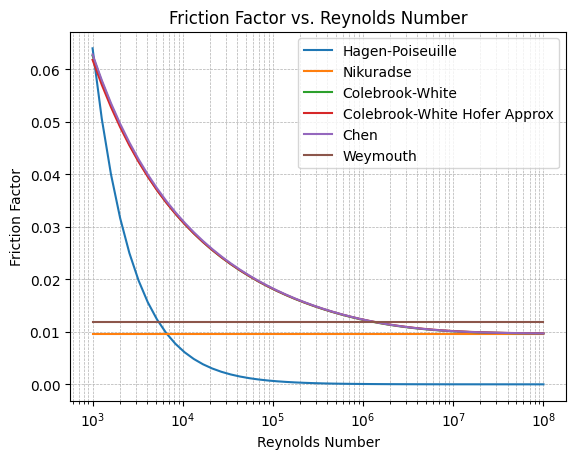

In [23]:
# Initialize result lists
friction_results_hagen_poiseuille = []
friction_results_nikuradse = []
friction_results_colebrook_white = []
friction_results_colebrook_white_hofer_approximation = []
friction_results_chen = []
friction_results_weymouth = []

diameter = 0.5  # m
roughness = 0.000015  # m

# Generate Reynolds numbers on a logarithmic scale
reynolds_numbers = np.logspace(3, 8, 50)

# Calculate friction factors for different models
for reynolds_number in reynolds_numbers:
    friction_results_hagen_poiseuille.append(hagen_poiseuille(reynolds_number))
    friction_results_nikuradse.append(nikuradse(d=diameter, epsilon=roughness))
    friction_results_colebrook_white.append(colebrook_white(epsilon=roughness, d=diameter, N_re=reynolds_number))
    friction_results_colebrook_white_hofer_approximation.append(colebrook_white_hofer_approximation(epsilon=roughness, d=diameter, N_re=reynolds_number))
    friction_results_chen.append(chen(epsilon=roughness, d=diameter, N_re=reynolds_number))
    friction_results_weymouth.append(weymouth(d=diameter))

# Plot the results
plt.figure()

plt.plot(reynolds_numbers, friction_results_hagen_poiseuille, label='Hagen-Poiseuille')
plt.plot(reynolds_numbers, friction_results_nikuradse, label='Nikuradse')
plt.plot(reynolds_numbers, friction_results_colebrook_white, label='Colebrook-White')
plt.plot(reynolds_numbers, friction_results_colebrook_white_hofer_approximation, label='Colebrook-White Hofer Approx')
plt.plot(reynolds_numbers, friction_results_chen, label='Chen')
plt.plot(reynolds_numbers, friction_results_weymouth, label='Weymouth')

# Configure plot
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Reynolds Number')
plt.ylabel('Friction Factor')
plt.title('Friction Factor vs. Reynolds Number')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

As it can be seen in the above plot, the Nikuradse and Weymouth friction models produce constant friction factors, because both equations don't take the Reynolds number as their inputs. The Chen, and both Colebrook-White friction factor models produce relatively similar results. While the Hagen-Poiseuille friction model, because it is only valid for the laminar flow regime, returns very low friction factor values in the turbulent zone. In GasNetSim the Chen friction method is set as default for flow rate calculation.

In [24]:
def volumetric_flow_rate(p1, p2, t1, t2, h1, h2, L, D, n_iter=0, d=RD, Z=Z, eta=0.85):
    # p_avg = calculate_average_pressure(p1, p2)
    t_avg = calculate_average_temperature(t1, t2)
    p_avg = calculate_average_pressure(p1, p2)
    e = height_effect(h1, h2, p1, p2, t1, t2)
    f_direction = flow_direction(p1, p2, e)
    if n_iter == 0:
        f = 0.01
    else:
        N_re = reynold_number(diameter=D,
                              velocity=volumetric_flow_rate(p1, p2, t1, t2, h1, h2, L, D, n_iter-1, d=RD, Z=Z, eta=0.85)*STANDARD_PRESSURE/STANDARD_TEMPERATURE * t_avg / p_avg/math.pi / (D/2)**2, 
                              rho=M_AIR * RD*p_avg/ Z / R/t_avg, 
                              viscosity=2e-4)
        f = chen(epsilon=0.000015, d=D, N_re=N_re)
    print(n_iter, f)
    return f_direction * eta * C1 * STANDARD_TEMPERATURE/STANDARD_PRESSURE * (abs(p1**2 - p2**2 - e) / (L*d*t_avg*Z))**0.5 * D**2.5 / f**0.5

In [25]:
volumetric_flow_rate(p1=0.05*bar,
                     p2=0.04999*bar,
                     t1=300,
                     t2=300,
                     h1=0,
                     h2=0,
                     L=100,
                     D=0.05,
                     n_iter=10)

0 0.01
1 0.028937170789683032
2 0.03306461716208442
3 0.033647919482515914
4 0.033725602006458674
5 0.03373586646151404
6 0.033737221330355845
7 0.03373740014334373
8 0.03373742374231141
9 0.03373742685679404
10 0.033737427267828926


8.030021512662679e-05

## 3 Pipeline outlet flow temperature

In [26]:
def calculate_beta_coefficient(ul, qm, cp, D):
    """

    :param ul: Heat transfer coefficient [W m^(-2) K^(-1)]
    :param qm: Mass flow [kg/s]
    :param cp: Specific heat capacity at constant pressure [J/(kg K)]
    :param D: pipeline diameter [m]
    :return:
    """
    return ul/(qm*cp) * math.pi * D

In [27]:
def calculate_gamma_coefficient(mu_jt, Z, R_specific, f, qm, p_avg, D):
    """

    :param mu_jt: Joule–Thomson coefficient [K/Pa]
    :param Z: Compressibility factor [-]
    :param R_specific:
    :param f: friction factor [-]
    :param qm: Mass flow rate [kg/s]
    :param p_avg: Average pressure [Pa]
    :param D: Pipeline diameter [m]
    :return: Gamma coefficient used for the calculation of pipeline outlet temperature
    """
    A = math.pi * (D/2)**2
    return mu_jt * Z * R_specific * f * qm * abs(qm) / (2*p_avg*D*A**2)

In [28]:
def calculate_pipeline_outlet_temperature(beta, gamma, Ts, L, T1):
    """

    :param beta: Beta coefficient used for the calculation of pipeline outlet temperature
    :param gamma: Gamma coefficient used for the calculation of pipeline outlet temperature
    :param Ts: Surrounding temperature [K]
    :param L: Pipeline length [m]
    :param T1: Temperature at pipeline inlet [K]
    :return: Temperature at pipeline outlet [K]
    """
    return beta/(beta-gamma)*(Ts - Ts * math.exp((gamma-beta)*L)) + T1*math.exp((gamma-beta)*L)

In [29]:
heat_transfer_coefficient = 3.69  #
mass_flow_rate = 55  # kg/s
Ts = 288.15
Cp = 2694.3337717294003
diameter = 0.5
JT = 3.2968900779744475e-06  # K/Pa
Z = 0.9393400065622768
R_specific = 0.5679360964034897
friction_factor = 0.01
average_pressure = 50e5

In [30]:
beta = calculate_beta_coefficient(heat_transfer_coefficient, mass_flow_rate, Cp, diameter)
gamma = calculate_gamma_coefficient(JT, Z, R_specific, friction_factor, mass_flow_rate, average_pressure, diameter)
T_outlet = calculate_pipeline_outlet_temperature(beta, gamma, Ts, 150000, 300)
print(beta, gamma)
print(T_outlet)

3.911399347293434e-05 2.7600843433158597e-10
288.1855772116586


In [31]:
dx = 1000
position = np.arange(0, 150000 + dx, dx)
Xs_EF = np.zeros(len(position))  # Euler forward
Xs_EB = np.zeros(len(position))  # Euler backward
Xs_TR = np.zeros(len(position))  # Trapizoid rule
Xs_analytic = np.zeros(len(position))  # Analytic

Xs_EF[0] = Xs_EB[0] = Xs_TR[0] = Xs_analytic[0] = 300

a = gamma - beta
b = beta * Ts
for i in range(1, 151):
    Xs_EF[i] = Xs_EF[i - 1] + dx * (a * Xs_EF[i - 1] + b)
    Xs_EB[i] = 1 / (1 - dx * a) * (Xs_EB[i - 1] + dx * b)
    Xs_TR[i] = (1 + dx * a / 2) / (1 - dx * a / 2) * Xs_TR[i - 1] + (dx * b) / (1 - dx * a / 2)
    Xs_analytic[i] = calculate_pipeline_outlet_temperature(beta, gamma, Ts, i*1e3, 300)

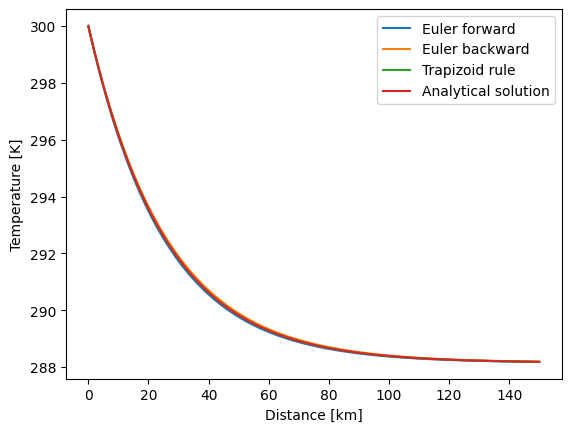

In [32]:
plt.figure()
plt.plot(Xs_EF, label="Euler forward")
plt.plot(Xs_EB, label="Euler backward")
plt.plot(Xs_TR, label="Trapizoid rule")
plt.plot(Xs_analytic, label="Analytical solution")
plt.xlabel("Distance [km]")
plt.ylabel("Temperature [K]")
plt.legend()
plt.show()